In [1]:
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.samplers import samplers
import seaborn as sns



2025-02-03 14:09:17.350709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738620557.365732  278130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738620557.370108  278130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 14:09:17.387714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from src.models import models
from src.models.standardgaussian import Gaussian

samples, metadata = samplers['nuts'](return_samples=True)(
        model=gym.targets.Banana(), 
        num_steps=1000,
        initial_position=jnp.ones(2), 
        key=jax.random.PRNGKey(0))


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


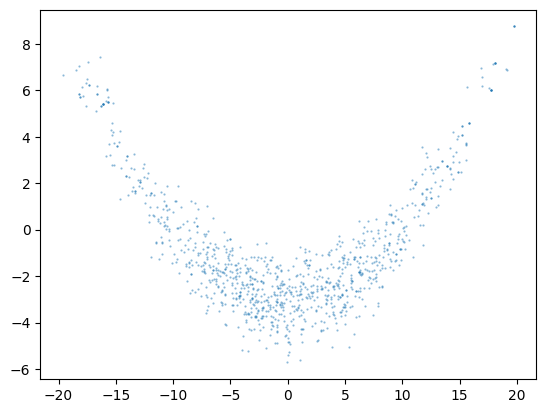

In [7]:
# scatter plot of samples
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

In [19]:
# load df from results
import itertools
import os
import pandas as pd

# show paths available
os.listdir(os.path.join('../', 'results'))

df = pd.concat([pd.read_csv(os.path.join('..','results', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: '../results/adjusted_microcanonical_Brownian_Motion.csv'

In [3]:
import numpy as np


def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({"nuts": "NUTS", "unadjusted_microcanonical": "Microcanonical (unadjusted)", "adjusted_microcanonical": "Microcanonical (adjusted)"}.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'Model',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["Model"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  # plt.yscale('log')

  plt.gcf().set_size_inches(10, 6)
  plt.show()

# display_results("Gaussian_10D", df, include_tuning=False)
display_results("Banana", df, include_tuning=False)

NameError: name 'df' is not defined

In [1]:
import sys
sys.path.append('..')
from src.samplers import samplers
from src.models import banana




2025-02-03 14:05:41.825200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738620341.839458  261284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738620341.844021  261284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
from src.models.rosenbrock import Rosenbrock_36D
import jax.numpy as jnp
import jax

Rosenbrock_36D().unnormalized_log_prob(jax.random.normal(shape=(36,), key=jax.random.PRNGKey(0)))

Array(-233.6276, dtype=float32)

In [5]:
samples, metadata = samplers['nuts'](return_samples=True)(
        model=Rosenbrock_36D(), 
        num_steps=1000,
        initial_position=jnp.ones(36), 
        key=jax.random.PRNGKey(0))

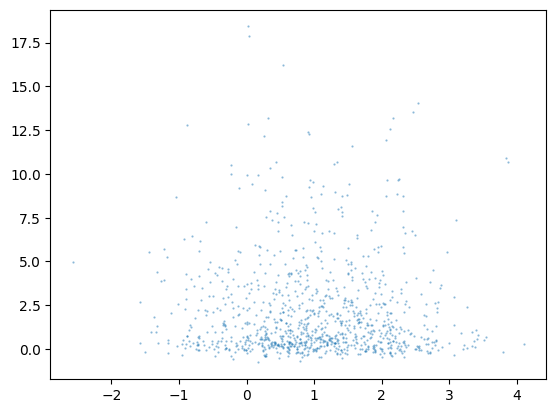

In [8]:
plt.scatter(samples[:,0], samples[:,-1], alpha=0.5, s=0.3)